In [86]:
# https://rhodesmill.org/skyfield/
"""
Skyfield version: 1.53
jplephem version: 2.22
sgp4 version: 2.24
Built-in leap seconds table ends with leap second at: 2016-12-31 23:59:60 UTC
Built-in ∆T table from finals2000A.all covers: 1973-01-01 to 2026-02-28
"""
import matplotlib.pyplot as plt
from skyfield.api import Loader, Topos, utc
from datetime import datetime, timedelta
import numpy as np
from datetime import datetime


In [87]:

# Setup Skyfield
load = Loader('~/skyfield-data')
ts = load.timescale()
eph = load('de421.bsp')
earth, sun, moon = eph['earth'], eph['sun'], eph['moon']

date=datetime.now().date()
print(date)

lat, lon, tz, hemi_lat, hemi_lon = 48.881953, 2.526959, 2, 'N' , 'E' #paris
#lat, lon, tz = 10.792418, 106.699402, 7 #ho chi minh
# lat, lon, tz = 13.7563, 100.5018, 6 #bangkok
# lat, lon = 1.3521, 103.8198 #singapore
# lat, lon = 35.6895, 139.6917 #tokyo
# lat, lon = 37.7749, -122.4194 #san francisco
# lat, lon = 40.7128, -74.0060 #new york
# lat, lon = 51.5074, -0.1278 #london
# lat, lon = 52.5200, 13.4050 #berlin
print(lat, lon, tz, hemi_lat, hemi_lon)

def convert(seconds):
    """
    Convert a float value in seconds to minutes and seconds.
    """
    minutes, sec = divmod(seconds, 60)
    if minutes<=9: m = '0' 
    else : m = ''
    if sec<=9:s = '0' 
    else : s = ''
    return f'{m}{int(minutes)}:{s}{round(sec, 2)}'
    #return f'{m}{seconds//60}:{s}{round((seconds-(seconds//60)*60),2)}'

def get_data():
    observer = earth + Topos(f"{lat} {hemi_lat}", f"{lon} {hemi_lon}")
    
    # Create time range (UTC)
    start = ts.utc(date.year, date.month, date.day, -tz, range(0, 1440, 1))
    sun_apparent = observer.at(start).observe(sun).apparent()
    moon_apparent = observer.at(start).observe(moon).apparent()
    sun_alt, sun_az, _ = sun_apparent.altaz()
    moon_alt, moon_az, _ = moon_apparent.altaz()

def convert_mn(current_time):
    # Convert the time to minutes in a day
    minutes_in_day = current_time.hour * 60 + current_time.minute
    #print(f"Current time: {current_time.strftime('%H:%M:%S')}, Minutes in day: {minutes_in_day}")
    return minutes_in_day

def plot_sun_moon_altitude(latitude, longitude, date, tz=0, hemi_lat='N', hemi_lon='E'):
    """Plot sun altitude without almanac module."""
    observer = earth + Topos(f"{latitude} {hemi_lat}", f"{longitude} {hemi_lon}")
    
    # Create time range (UTC)
    start = ts.utc(date.year, date.month, date.day, -tz, range(0, 1440, 1))
    sun_apparent = observer.at(start).observe(sun).apparent()
    moon_apparent = observer.at(start).observe(moon).apparent()
    sun_alt, sun_az, _ = sun_apparent.altaz()
    moon_alt, moon_az, _ = moon_apparent.altaz()
    #print(alt.degrees, len(alt.degrees), max(alt.degrees))
    #print(az.degrees)#, len(alt.degrees), max(alt.degrees))
    # Convert to local hours
    hours = np.linspace(0, 24, len(sun_alt.degrees))
    # Get the current time
    current_time = datetime.now() #tz=utc)
    
    #print(np.sign(alt.degrees), np.diff(np.sign(alt.degrees)),np.where(np.diff(np.sign(alt.degrees))))
    # Find sunrise/sunset crossings manually
    noon = convert(np.argmax(sun_alt.degrees)+1)
    crossings = np.where(np.diff(np.sign(sun_alt.degrees)))[0]  # in minutes
    #print(crossings/60)
    sunrise = convert(crossings[0]-4)
    sunset = convert(crossings[1]+5)
    sunrise_az = sun_az.degrees[crossings[0]-4]
    sunset_az = sun_az.degrees[crossings[1]+5]
    #print('Sun:',sunrise, sunset)

    # Find moonrise/moonset crossings manually
    #noon = convert(np.argmax(moon_alt.degrees)+1)
    crossings2 = np.where(np.diff(np.sign(moon_alt.degrees)))[0]  # in minutes
    #print(crossings2/60, moon_alt.degrees[crossings2[0]+1], moon_alt.degrees[crossings2[1]+1])
    #moonrise = convert(crossings2[0]-4)
    #moonset = convert(crossings2[1]+1)
    #moonrise_az = moon_az.degrees[crossings2[0]+1]
    #moonset_az = moon_az.degrees[crossings2[1]+1]
    #print('Moon:',moonrise, moonset)
    
    now_mn = convert_mn(current_time) #+ tz*60
    #print(now_mn)
    print(f'Sunrise at: {sunrise} - Sunset at: {sunset} Noon: {noon}')
    print(f'Altitude: {sun_alt.degrees[now_mn]} - Azimuth: {sun_az.degrees[now_mn]}')
    print('Noon high:',max(sun_alt.degrees), 'Midnight low:',min(sun_alt.degrees))
    # Plot
    fig, ax = plt.subplots(1, 1,figsize=(12, 6))
    plt.plot(hours, sun_alt.degrees, 'b-')
    plt.plot(hours, moon_alt.degrees, 'g-.')
    plt.plot(hours[now_mn], sun_alt.degrees[now_mn],'ro',label=f'Sun alt : {round(sun_alt.degrees[now_mn],2)}\nSun az : {round(sun_az.degrees[now_mn],2)}')
    plt.plot(hours[now_mn], moon_alt.degrees[now_mn],'go',label=f'Moon alt : {round(moon_alt.degrees[now_mn],2)}\nMoon az : {round(moon_az.degrees[now_mn],2)}')
    plt.axhline(0, color='gray', linestyle='--')
    
    # Mark crossings
    for i in crossings:
        if sun_alt.degrees[i] < 0:  # Sunrise
            plt.axvline(hours[i], color='orange', linestyle=':', label=f'Sunrise : {sunrise}' if i == crossings[0] else "")
        else:  # Sunset
            plt.axvline(hours[i], color='red', linestyle=':', label=f'Sunset : {sunset}' if i == crossings[1] else "")
    
    plt.title(f"Sun-Moon Altitude on {current_time.strftime('%Y-%m-%d at %H:%M')}")
    plt.xlabel('Local Time (hours)')
    plt.ylabel('Altitude (degrees)')
    #plt.xticks()
    ax.set_xticks(range(0,24), labels=[str(i) for i in range(0,24)])
    plt.legend()
    plt.grid()
    plt.show()


2025-07-14
48.881953 2.526959 2 N E


In [88]:
def plot_sun_moon_azimuth(latitude, longitude, date, tz=0, hemi_lat='N', hemi_lon='E'):
    """Plot sun altitude without almanac module."""
    observer = earth + Topos(f"{latitude} {hemi_lat}", f"{longitude} {hemi_lon}")
    
    # Create time range (UTC)
    start = ts.utc(date.year, date.month, date.day, -tz, range(0, 1440, 1))
    sun_apparent = observer.at(start).observe(sun).apparent()
    moon_apparent = observer.at(start).observe(moon).apparent()
    sun_alt, sun_az, _ = sun_apparent.altaz()
    moon_alt, moon_az, _ = moon_apparent.altaz()
    #print(alt.degrees, len(alt.degrees), max(alt.degrees))
    #print(az.degrees)#, len(alt.degrees), max(alt.degrees))
    # Convert to local hours
    hours = np.linspace(0, 24, len(sun_alt.degrees))
    # Get the current time
    current_time = datetime.now() #tz=utc)
    
    #print(np.sign(alt.degrees), np.diff(np.sign(alt.degrees)),np.where(np.diff(np.sign(alt.degrees))))
    # Find sunrise/sunset crossings manually
    noon = convert(np.argmax(sun_alt.degrees)+1)
    crossings = np.where(np.diff(np.sign(sun_alt.degrees)))[0]  # in minutes
    #print(crossings/60)
    sunrise = convert(crossings[0]-4)
    sunset = convert(crossings[1]+5)
    sunrise_az = sun_az.degrees[crossings[0]-4]
    sunset_az = sun_az.degrees[crossings[1]+5]
    #print('Sun:',sunrise, sunset)

    # Find moonrise/moonset crossings manually
    noon = convert(np.argmax(moon_alt.degrees)+1)
    crossings = np.where(np.diff(np.sign(moon_alt.degrees)))[0]  # in minutes
    
    print('crossings',crossings/60)

    moonrise = convert(crossings[0]-4)
    moonrise_az = moon_az.degrees[crossings[0]-4]
    try:        
        moonset = convert(crossings[1]+5)
        moonset_az = moon_az.degrees[crossings[1]+5]   
    except: 
        moonset = 'unknown'

    print('Moon:',moonrise, moonset)
    now_mn = convert_mn(current_time) #+ tz*60
    
    print(f'Moonrise at: {moonrise} - Moonset at: {moonset} Noon: {noon}')
    print(f'Altitude: {moon_alt.degrees[now_mn]} - Azimuth: {moon_az.degrees[now_mn]}')
    print(f'Delta azimuth: {abs(sun_az.degrees[now_mn] - moon_az.degrees[now_mn])}')
    # Plot
    fig, ax = plt.subplots(1, 1,figsize=(12, 6))
    plt.plot(hours, sun_az.degrees, 'b-')
    plt.plot(hours, moon_az.degrees, 'g-.')
    plt.plot(hours[now_mn], sun_az.degrees[now_mn],'ro',label=f'Sun alt : {round(sun_alt.degrees[now_mn],2)}\nSun az : {round(sun_az.degrees[now_mn],2)}')
    plt.plot(hours[now_mn], moon_az.degrees[now_mn],'go',label=f'Moon alt : {round(moon_alt.degrees[now_mn],2)}\nMoon az : {round(moon_az.degrees[now_mn],2)}')
    plt.axhline(sunrise_az, color='gray', linestyle='--')
    plt.axhline(sunset_az, color='gray', linestyle='--')
    plt.axhline(180, color='gray', linestyle='--')
    
    """
    # Mark crossings
    # for i in crossings:
    #   if if sunrise_az.degrees[i] = 0:  # Sunrise
            plt.axvline((crossings[0]-4)/60, color='orange', linestyle=':', label=f'Sunrise : {sunrise}')# if i == crossings[0] else "")
    #   else:  # Sunset
            plt.axvline((crossings[1]+5)/60, color='red', linestyle=':', label=f'Sunset : {sunset}')# if i == crossings[1] else "")
    """
    
    plt.title(f"Sun-Moon Azimuth on {current_time.strftime('%Y-%m-%d at %H:%M')}")
    plt.xlabel('Local Time (hours)')
    plt.ylabel('Azimuth (degrees)')
    #plt.xticks()
    ax.set_xticks(range(0,24), labels=[str(i) for i in range(0,24)])
    plt.legend()
    #plt.grid()
    plt.show()



In [89]:
def scatter_position():
    """Scatter altitude, azimuth without almanac module."""
    latitude=lat
    longitude=lon
    #tz = tz
    hemi_lat='N'
    hemi_lon='E'
    date=datetime.now().date()
    observer = earth + Topos(f"{latitude} {hemi_lat}", f"{longitude} {hemi_lon}")

    # Create time range (UTC)
    start = ts.utc(date.year, date.month, date.day, -tz, range(0, 1440, 1))
    sun_apparent = observer.at(start).observe(sun).apparent()
    moon_apparent = observer.at(start).observe(moon).apparent()
    sun_alt, sun_az, _ = sun_apparent.altaz()
    moon_alt, moon_az, _ = moon_apparent.altaz()

    # Get the current time
    current_time = datetime.now() #tz=utc)
    now_mn = convert_mn(current_time) #+ tz*60
    # Plot
    fig, ax = plt.subplots(1, 1,figsize=(12, 6))
    plt.title(f"Sun-Moon positions on {current_time.strftime('%Y-%m-%d at %H:%M')}")
    plt.ylabel('Altitude (degrees)')
    plt.xlabel('Azimuth (degrees)')
    plt.scatter(sun_az.degrees, sun_alt.degrees,s=1,color='orange')
    plt.scatter(moon_az.degrees, moon_alt.degrees,s=1,color='grey')
    plt.plot(sun_az.degrees[now_mn], sun_alt.degrees[now_mn],'ro',label=f'Sun alt : {round(sun_alt.degrees[now_mn],2)}\nSun az : {round(sun_az.degrees[now_mn],2)}')
    plt.plot(moon_az.degrees[now_mn], moon_alt.degrees[now_mn],'go',label=f'Moon alt : {round(moon_alt.degrees[now_mn],2)}\nMoon az : {round(moon_az.degrees[now_mn],2)}')
    plt.axhline(0, color='gray', linestyle='--') 
    plt.axvline(180, color='gray', linestyle='--')  
    plt.legend()

Sunrise at: 04:03 - Sunset at: 19:48 Noon: 11:57
Altitude: 60.722470843669974 - Azimuth: 205.92737102567776
Noon high: 62.709502089061004 Midnight low: -19.60587655246185


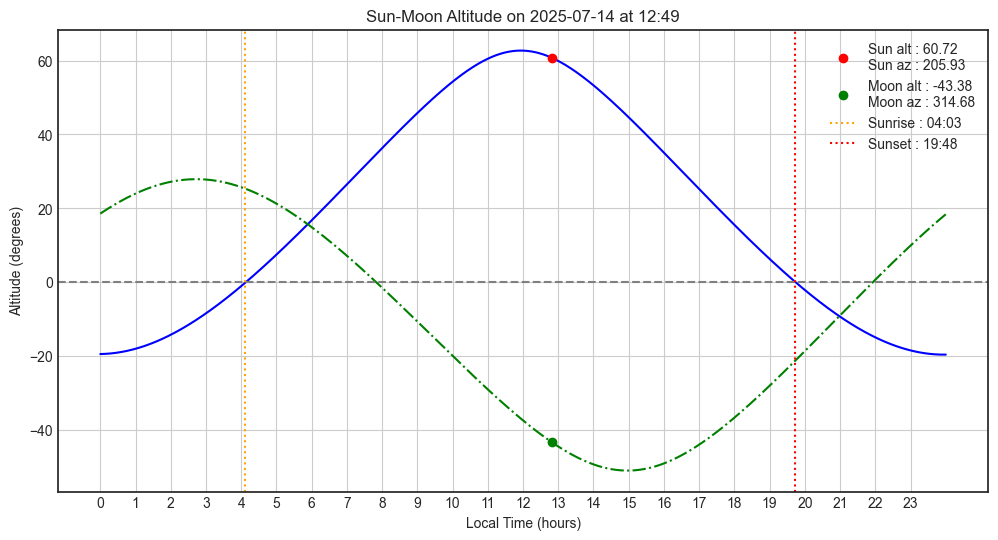

crossings [ 7.81666667 21.9       ]
Moon: 07:45 21:59
Moonrise at: 07:45 - Moonset at: 21:59 Noon: 02:44
Altitude: -43.376087118634175 - Azimuth: 314.67818277062287
Delta azimuth: 108.75081174494511


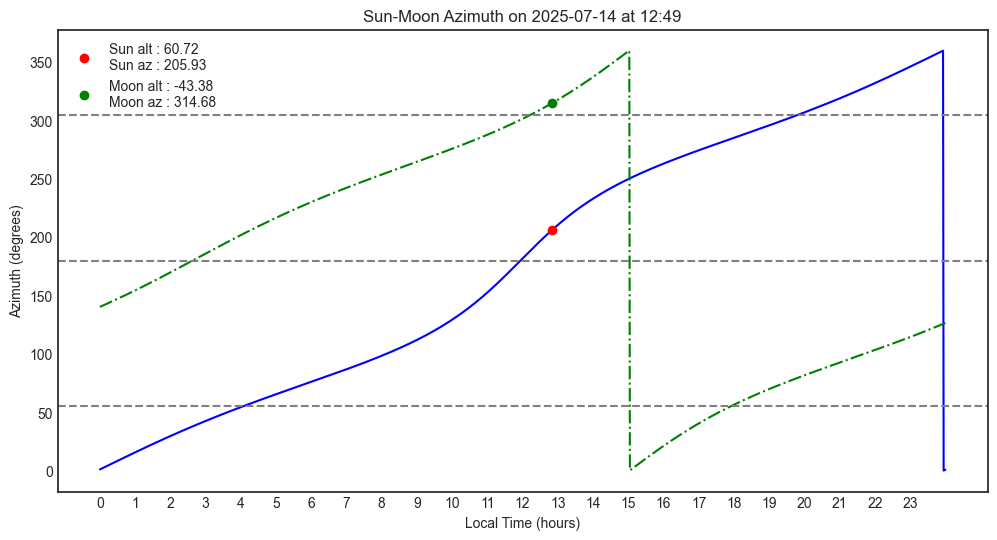

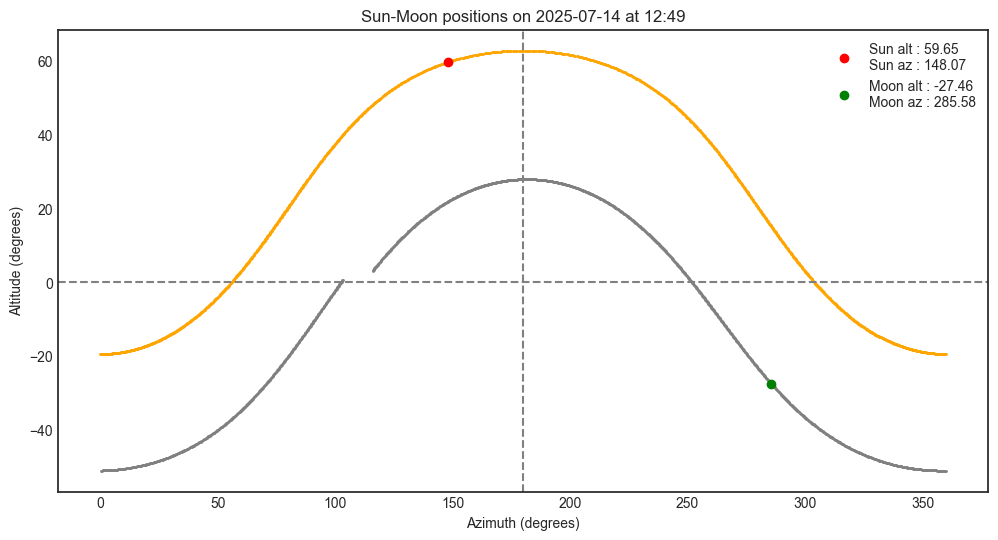

In [90]:
# Example usage
plot_sun_moon_altitude(
    latitude=lat,
    longitude=lon,
    date=date,

)

# Example usage
plot_sun_moon_azimuth(
    latitude=lat,
    longitude=lon,
    date=date
)


scatter_position()

In [91]:
# Define all moon phases with their ranges
phases = [
    (0.0, 0.03, "🌑", "New Moon"),
    (0.03, 0.24, "🌒", "Waxing Crescent"),
    (0.24, 0.26, "🌓", "First Quarter"),
    (0.26, 0.48, "🌔", "Waxing Gibbous"),
    (0.48, 0.52, "🌕", "Full Moon"),
    (0.52, 0.74, "🌖", "Waning Gibbous"),
    (0.74, 0.76, "🌗", "Last Quarter"),
    (0.76, 0.97, "🌘", "Waning Crescent"),
    (0.97, 1.0, "🌑", "New Moon")
]

In [92]:
def calculate_lunar_phase(date=None):
        """Calculate the lunar phase (0-1) for a given date."""
        if date is None:
            date = datetime.now()
        
        known_new_moon = datetime(2000, 1, 6, 18, 14)
        lunar_cycle = 29.530588
        delta = date - known_new_moon
        days_since = delta.total_seconds() / 86400
        phase = (days_since % lunar_cycle) / lunar_cycle
        return phase, date


In [93]:
def get_symbol(phase):
    # Display all phases and find current phase
    for i, (start, end, sym, name) in enumerate(phases):
        #phase = 0.95
        # Check if current phase falls in this range
        is_current = (start <= phase < end)  
        
        if is_current:
            #print(start, end, sym, name)
            return (sym, name)
        #print(start, end, sym, name)

In [94]:
import calendar

# Get the number of days in the month for the given 'date'
month_length = calendar.monthrange(date.year, date.month)[1]
print(f"Number of days in {date.strftime('%B %Y')}: {month_length}")
for d in range(month_length):
    first_day_of_month = datetime.now().replace(day=1, hour=12, minute=0, second=0, microsecond=0)  # Reference date for the lunar phase calculation
    current = first_day_of_month + timedelta(days=d)
    phase, date = calculate_lunar_phase(current)
    emoji, name = get_symbol(phase)
    print(f"{current.strftime('%Y-%m-%d %H:%M')}: {emoji} {name} ({phase:.2f})")


Number of days in July 2025: 31
2025-07-01 12:00: 🌒 Waxing Crescent (0.19)
2025-07-02 12:00: 🌒 Waxing Crescent (0.22)
2025-07-03 12:00: 🌓 First Quarter (0.26)
2025-07-04 12:00: 🌔 Waxing Gibbous (0.29)
2025-07-05 12:00: 🌔 Waxing Gibbous (0.33)
2025-07-06 12:00: 🌔 Waxing Gibbous (0.36)
2025-07-07 12:00: 🌔 Waxing Gibbous (0.39)
2025-07-08 12:00: 🌔 Waxing Gibbous (0.43)
2025-07-09 12:00: 🌔 Waxing Gibbous (0.46)
2025-07-10 12:00: 🌕 Full Moon (0.49)
2025-07-11 12:00: 🌖 Waning Gibbous (0.53)
2025-07-12 12:00: 🌖 Waning Gibbous (0.56)
2025-07-13 12:00: 🌖 Waning Gibbous (0.60)
2025-07-14 12:00: 🌖 Waning Gibbous (0.63)
2025-07-15 12:00: 🌖 Waning Gibbous (0.66)
2025-07-16 12:00: 🌖 Waning Gibbous (0.70)
2025-07-17 12:00: 🌖 Waning Gibbous (0.73)
2025-07-18 12:00: 🌘 Waning Crescent (0.77)
2025-07-19 12:00: 🌘 Waning Crescent (0.80)
2025-07-20 12:00: 🌘 Waning Crescent (0.83)
2025-07-21 12:00: 🌘 Waning Crescent (0.87)
2025-07-22 12:00: 🌘 Waning Crescent (0.90)
2025-07-23 12:00: 🌘 Waning Crescent (0.93)


In [95]:
phase, date = calculate_lunar_phase(datetime.now())
print(date.strftime('%Y-%m-%d %H:%M'), f'({phase:.2f})')
phase, date.strftime('%Y-%m-%d %H:%M')
get_symbol(phase)

2025-07-14 12:49 (0.63)


('🌖', 'Waning Gibbous')

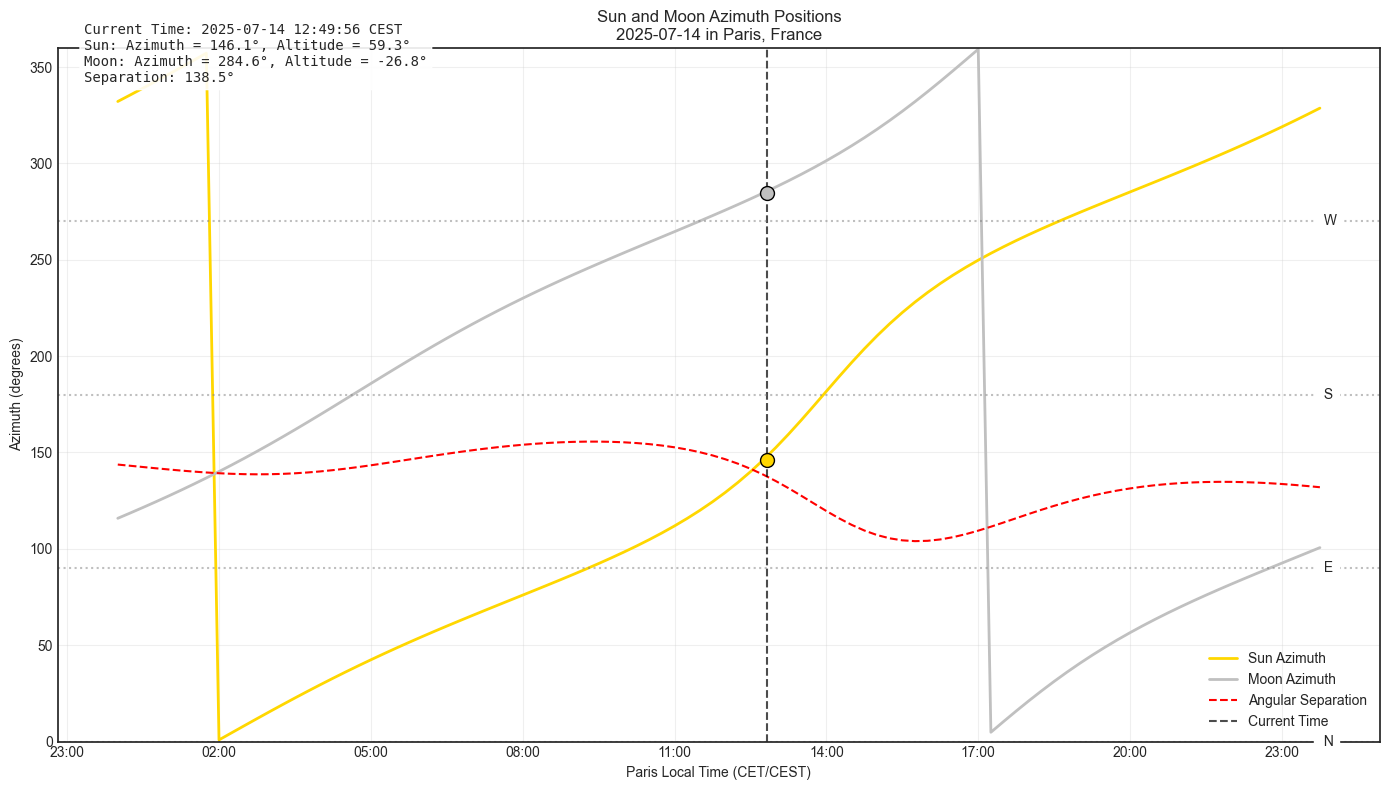

In [96]:
import matplotlib.pyplot as plt
import numpy as np
from skyfield.api import load, Topos
from datetime import datetime, timedelta
import pytz
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# Load ephemeris and timescale
eph = load('de421.bsp')
ts = load.timescale()

# Paris, France coordinates
latitude = 48.8566  # °N
longitude = 2.3522   # °E
timezone = 'Europe/Paris'  # Paris timezone

# Set up observer location
observer = eph['earth'] + Topos(f'{latitude} N', f'{longitude} E')

# Get current time in Paris
paris_tz = pytz.timezone(timezone)
current_time = datetime.now(paris_tz)

# Time range for today (Paris local time)
start_time = current_time.replace(hour=0, minute=0, second=0, microsecond=0)
end_time = start_time + timedelta(days=1)

# Create time points every 15 minutes
times = [start_time + timedelta(minutes=15*i) for i in range(24*4)]
skyfield_times = ts.from_datetimes([t.astimezone(pytz.UTC) for t in times])  # Convert to UTC for Skyfield

# Calculate positions
sun_azimuths = []
moon_azimuths = []
distances = []
altitudes = []

for t in skyfield_times:
    # Observe Sun
    sun_apparent = observer.at(t).observe(eph['sun']).apparent()
    sun_alt, sun_az, _ = sun_apparent.altaz()
    
    # Observe Moon
    moon_apparent = observer.at(t).observe(eph['moon']).apparent()
    moon_alt, moon_az, _ = moon_apparent.altaz()
    
    # Calculate distance
    sun_az_deg = sun_az.degrees % 360
    moon_az_deg = moon_az.degrees % 360
    distance = min((moon_az_deg - sun_az_deg) % 360, 
                   (sun_az_deg - moon_az_deg) % 360)
    
    sun_azimuths.append(sun_az_deg)
    moon_azimuths.append(moon_az_deg)
    distances.append(distance)
    altitudes.append((sun_alt.degrees, moon_alt.degrees))

# Get current time data
current_idx = min(range(len(times)), key=lambda i: abs((times[i] - current_time).total_seconds()))
current_sun_az = sun_azimuths[current_idx]
current_moon_az = moon_azimuths[current_idx]
current_distance = distances[current_idx]
current_sun_alt, current_moon_alt = altitudes[current_idx]

# Create plot
plt.figure(figsize=(14, 8))

# Plot Sun and Moon azimuth
sun_line, = plt.plot(times, sun_azimuths, label='Sun Azimuth', color='gold', linewidth=2)
moon_line, = plt.plot(times, moon_azimuths, label='Moon Azimuth', color='silver', linewidth=2)

# Plot distance
dist_line, = plt.plot(times, distances, label='Angular Separation', color='red', linestyle='--')

# Mark current time
current_time_marker = plt.axvline(current_time, color='black', linestyle='--', alpha=0.7)
plt.scatter([current_time], [current_sun_az], color='gold', s=100, edgecolor='black', zorder=5)
plt.scatter([current_time], [current_moon_az], color='silver', s=100, edgecolor='black', zorder=5)

# Add text box with current positions
current_time_str = current_time.strftime('%Y-%m-%d %H:%M:%S %Z')
text_content = (
    f"Current Time: {current_time_str}\n"
    f"Sun: Azimuth = {current_sun_az:.1f}°, Altitude = {current_sun_alt:.1f}°\n"
    f"Moon: Azimuth = {current_moon_az:.1f}°, Altitude = {current_moon_alt:.1f}°\n"
    f"Separation: {current_distance:.1f}°"
)

plt.annotate(text_content, xy=(0.02, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
             fontfamily='monospace')

# Format plot
title = f'Sun and Moon Azimuth Positions\n{start_time.date()} in Paris, France'
plt.title(title)
plt.xlabel('Paris Local Time (CET/CEST)')
plt.ylabel('Azimuth (degrees)')
plt.ylim(0, 360)
plt.grid(True, alpha=0.3)

# Format x-axis with local time
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M', tz=paris_tz))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))

# Add compass directions
for direction, angle in [('N', 0), ('E', 90), ('S', 180), ('W', 270)]:
    plt.axhline(angle, color='gray', linestyle=':', alpha=0.5)
    plt.text(times[-1], angle, f' {direction}', va='center', ha='left', backgroundcolor='white')

plt.legend(handles=[sun_line, moon_line, dist_line, current_time_marker], 
           labels=['Sun Azimuth', 'Moon Azimuth', 'Angular Separation', 'Current Time'])

plt.tight_layout()

# Save and show
filename = f'sun_moon_azimuth_paris_{current_time.date()}.png'
#plt.savefig(filename, dpi=150, bbox_inches='tight')
#print(f"Plot saved as {filename}")
plt.show()


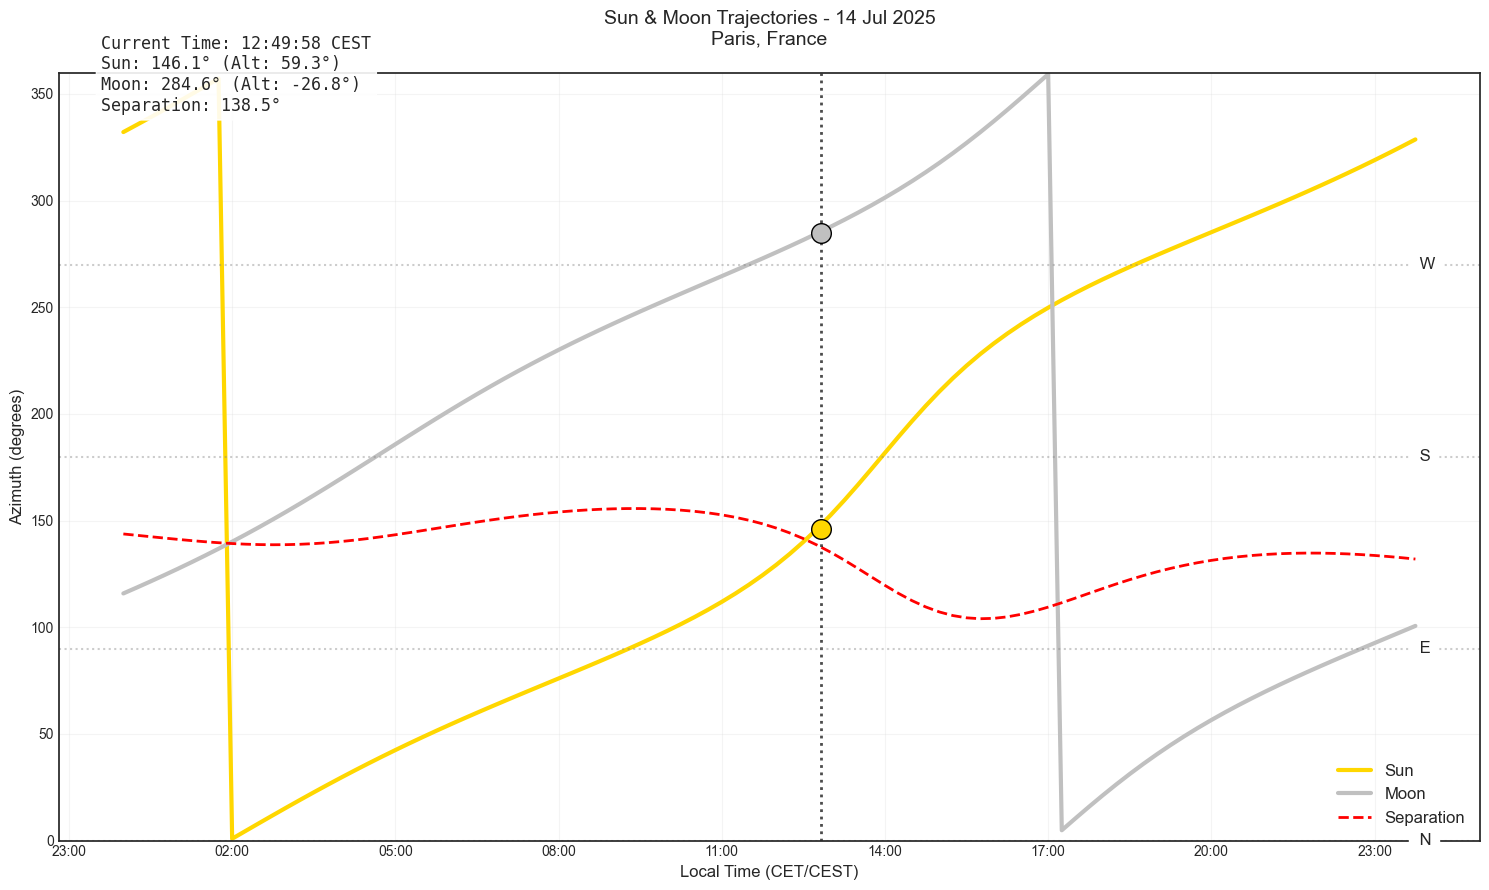

In [97]:
import matplotlib.pyplot as plt
import numpy as np
from skyfield.api import load, Topos
from datetime import datetime, timedelta
import pytz
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from matplotlib.patches import Circle

# Load ephemeris
eph = load('de421.bsp')
ts = load.timescale()

# Paris configuration
PARIS = {
    'latitude': 48.8566,
    'longitude': 2.3522,
    'timezone': 'Europe/Paris',
    'name': 'Paris, France'
}

# Set up observer
observer = eph['earth'] + Topos(f"{PARIS['latitude']} N", f"{PARIS['longitude']} E")
tz = pytz.timezone(PARIS['timezone'])
now = datetime.now(tz)

# Time range for today (local)
today_start = now.replace(hour=0, minute=0, second=0, microsecond=0)
times = [today_start + timedelta(minutes=15*i) for i in range(24*4)]
skyfield_times = ts.from_datetimes([t.astimezone(pytz.UTC) for t in times])

# Calculate positions
def calculate_positions():
    sun_az, moon_az, dist, alts = [], [], [], []
    for t in skyfield_times:
        # Sun
        sun = observer.at(t).observe(eph['sun']).apparent()
        sun_alt, sun_a, _ = sun.altaz()
        # Moon
        moon = observer.at(t).observe(eph['moon']).apparent()
        moon_alt, moon_a, _ = moon.altaz()
        # Distance
        d = min((moon_a.degrees - sun_a.degrees) % 360,
                (sun_a.degrees - moon_a.degrees) % 360)
        
        sun_az.append(sun_a.degrees % 360)
        moon_az.append(moon_a.degrees % 360)
        dist.append(d)
        alts.append((sun_alt.degrees, moon_alt.degrees))
    return sun_az, moon_az, dist, alts

sun_az, moon_az, distances, altitudes = calculate_positions()

# Current position data
current_idx = min(range(len(times)), key=lambda i: abs((times[i] - now).total_seconds()))
current_data = {
    'sun_az': sun_az[current_idx],
    'moon_az': moon_az[current_idx],
    'distance': distances[current_idx],
    'sun_alt': altitudes[current_idx][0],
    'moon_alt': altitudes[current_idx][1]
}

# Create plot
plt.figure(figsize=(15, 9))
ax = plt.gca()

# Plot trajectories
sun_line, = ax.plot(times, sun_az, color='#FFD700', lw=3, label='Sun')
moon_line, = ax.plot(times, moon_az, color='#C0C0C0', lw=3, label='Moon')
dist_line, = ax.plot(times, distances, 'r--', lw=2, label='Separation')

# Current time markers
ax.axvline(now, color='k', ls=':', alpha=0.7, lw=2)
ax.scatter([now], [current_data['sun_az']], color='#FFD700', s=200, ec='k', zorder=5)
ax.scatter([now], [current_data['moon_az']], color='#C0C0C0', s=200, ec='k', zorder=5)

# Add horizon compass
compass_style = {'color': 'gray', 'ls': ':', 'alpha': 0.4}
for angle, label in [(0, 'N'), (90, 'E'), (180, 'S'), (270, 'W')]:
    ax.axhline(angle, **compass_style)
    ax.text(times[-1], angle, f' {label}', va='center', ha='left', 
            backgroundcolor='white', fontsize=12)

# Info box
info_text = (
    f"Current Time: {now.strftime('%H:%M:%S %Z')}\n"
    f"Sun: {current_data['sun_az']:.1f}° (Alt: {current_data['sun_alt']:.1f}°)\n"
    f"Moon: {current_data['moon_az']:.1f}° (Alt: {current_data['moon_alt']:.1f}°)\n"
    f"Separation: {current_data['distance']:.1f}°"
)
ax.annotate(info_text, xy=(0.03, 0.95), xycoords='axes fraction',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            fontfamily='monospace', fontsize=12)

# Formatting
ax.set_title(f"Sun & Moon Trajectories - {now.strftime('%d %b %Y')}\n{PARIS['name']}",
             fontsize=14, pad=20)
ax.set_xlabel('Local Time (CET/CEST)', fontsize=12)
ax.set_ylabel('Azimuth (degrees)', fontsize=12)
ax.set_ylim(0, 360)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M', tz=tz))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax.grid(True, alpha=0.2)
ax.legend(loc='lower right', fontsize=12)

# Add decorative elements
#ax.add_patch(Circle((0.92, 0.1), 0.05, color='#FFD700', transform=ax.transAxes))
#ax.add_patch(Circle((0.85, 0.1), 0.05, color='#C0C0C0', transform=ax.transAxes))

plt.tight_layout()

# Save and show
filename = f"sun_moon_paris_{now.strftime('%Y%m%d')}.png"
#plt.savefig(filename, dpi=150, bbox_inches='tight')
#print(f"✓ Plot saved as {filename}")
plt.show()


In [98]:
import numpy as np
import matplotlib.pyplot as plt
from skyfield.api import load, Topos
from datetime import datetime, timedelta
import pytz
import matplotlib.dates as mdates
from scipy.signal import savgol_filter
from matplotlib.patches import Circle
import seaborn as sns

# Load ephemeris
eph = load('de421.bsp')
ts = load.timescale()

# Parisian Waltz Configuration
PARIS_WALTZ = {
    'lat': 48.8566,  # Dance floor latitude
    'lon': 2.3522,   # Dance floor longitude
    'tz': 'Europe/Paris',
    'colors': {
        'sun': '#FF6B00',  # Warm orange
        'moon': '#5D8AA8', # Cool steel blue
        'sky': '#F0F8FF',  # Alice blue background
        'floor': '#FFF5EE' # Seashell plot background
    }
}


In [99]:

# Initialize dance floor
#plt.style.use('seaborn-white')
sns.set_style('whitegrid')
plt.rcParams['figure.facecolor'] = 'white'


In [100]:
import matplotlib.style as mplstyle
#Set style safely
try:
    plt.style.use('seaborn-v0_8-white')  # Modern matplotlib uses this
    print('seaborn')
except:
    mplstyle.use('classic')  # Fallback to basic style

seaborn


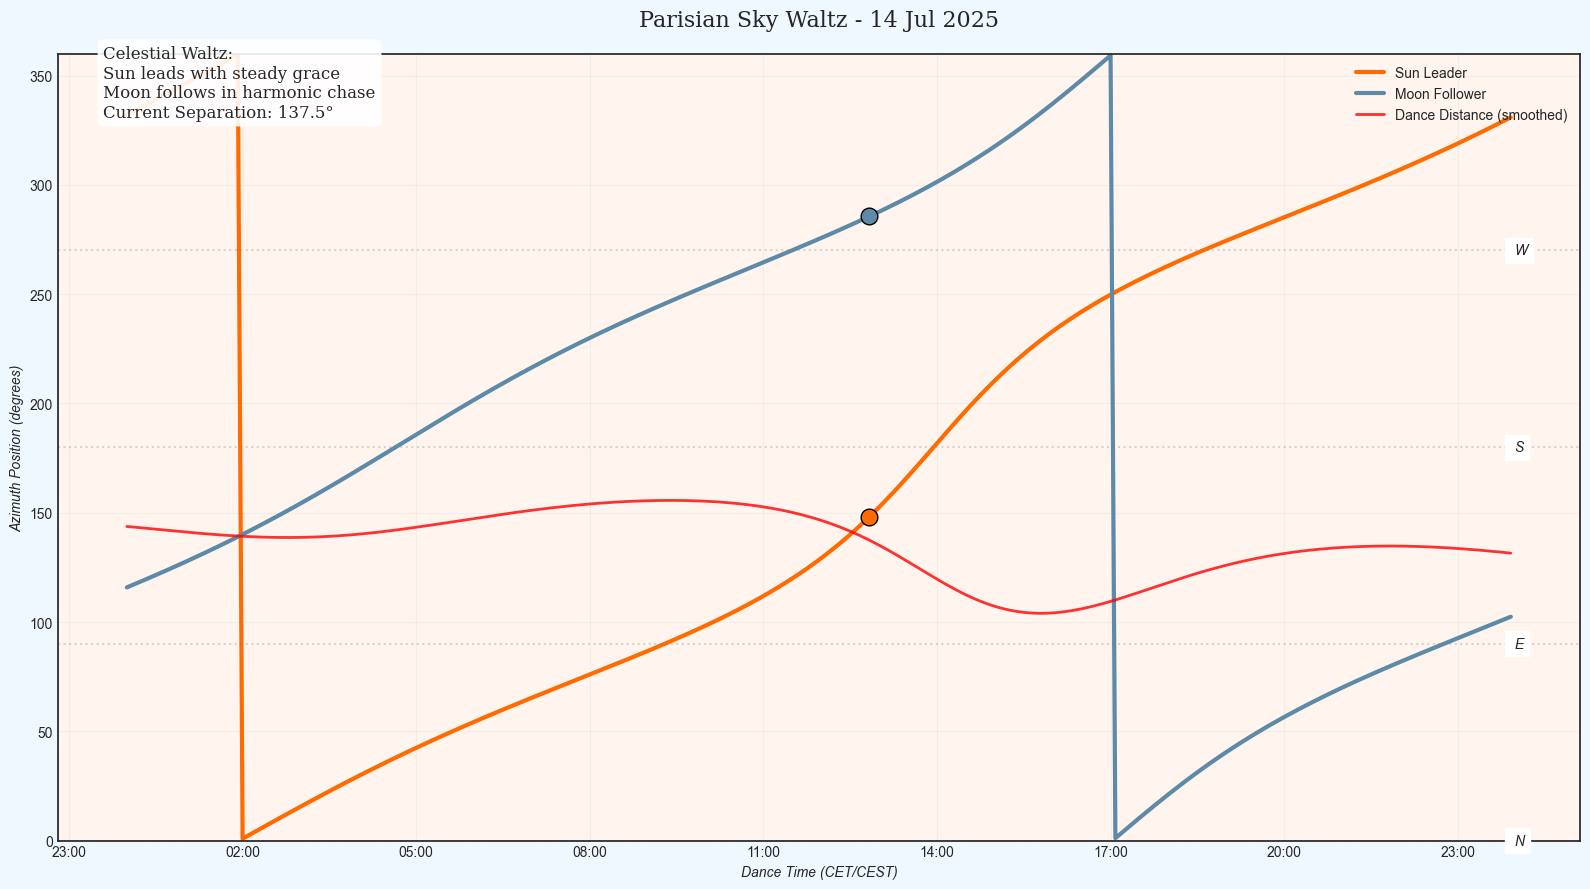

In [101]:
fig, ax = plt.subplots(figsize=(16, 9), facecolor=PARIS_WALTZ['colors']['sky'])
ax.set_facecolor(PARIS_WALTZ['colors']['floor'])

# Celestial dancers
observer = eph['earth'] + Topos(f"{PARIS_WALTZ['lat']} N", 
                               f"{PARIS_WALTZ['lon']} E")
tz = pytz.timezone(PARIS_WALTZ['tz'])
now = datetime.now(tz)

# Waltz timing (5-minute steps)
waltz_times = [now.replace(hour=0, minute=0, second=0) + timedelta(minutes=5*i) 
               for i in range(24*12)]
skyfield_times = ts.from_datetimes([t.astimezone(pytz.UTC) for t in waltz_times])

# Track dance positions
positions = {
    'sun_az': np.zeros(len(waltz_times)),
    'moon_az': np.zeros(len(waltz_times)),
    'distance': np.zeros(len(waltz_times))
}

for i, t in enumerate(skyfield_times):
    # Sun's elegant steps
    sun_altaz = observer.at(t).observe(eph['sun']).apparent().altaz()
    positions['sun_az'][i] = sun_altaz[1].degrees % 360
    
    # Moon's graceful response
    moon_altaz = observer.at(t).observe(eph['moon']).apparent().altaz()
    positions['moon_az'][i] = moon_altaz[1].degrees % 360
    
    # Calculate the dance distance
    positions['distance'][i] = min(
        (positions['moon_az'][i] - positions['sun_az'][i]) % 360,
        (positions['sun_az'][i] - positions['moon_az'][i]) % 360
    )

# Smooth the waltz rhythm
smoothed_dist = savgol_filter(positions['distance'], window_length=21, polyorder=3)

# Plot the celestial waltz
plot_times = mdates.date2num(waltz_times)
ax.plot(plot_times, positions['sun_az'], color=PARIS_WALTZ['colors']['sun'], 
        lw=3, label='Sun Leader')
ax.plot(plot_times, positions['moon_az'], color=PARIS_WALTZ['colors']['moon'], 
        lw=3, label='Moon Follower')
ax.plot(plot_times, smoothed_dist, 'r-', alpha=0.8, lw=2, 
        label='Dance Distance (smoothed)')

# Highlight current position in the waltz
current_x = mdates.date2num(now)
current_idx = np.argmin(np.abs(plot_times - current_x))
ax.plot(current_x, positions['sun_az'][current_idx], 'o', 
        color=PARIS_WALTZ['colors']['sun'], ms=12, mec='k')
ax.plot(current_x, positions['moon_az'][current_idx], 'o', 
        color=PARIS_WALTZ['colors']['moon'], ms=12, mec='k')

# Add dance floor compass
for angle, label in [(0, 'N'), (90, 'E'), (180, 'S'), (270, 'W')]:
    ax.axhline(angle, color='gray', ls=':', alpha=0.3)
    ax.text(plot_times[-1], angle, f' {label}', ha='left', va='center', 
            backgroundcolor='white', fontstyle='italic')

# Annotate the dance
ax.annotate('Celestial Waltz:\n'
            'Sun leads with steady grace\n'
            'Moon follows in harmonic chase\n'
            f"Current Separation: {positions['distance'][current_idx]:.1f}°",
            xy=(0.03, 0.92), xycoords='axes fraction',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            fontfamily='serif', fontsize=12)

# Final choreography
ax.set_title(f"Parisian Sky Waltz - {now.strftime('%d %b %Y')}", 
             fontsize=16, pad=20, fontfamily='serif')
ax.set_xlabel('Dance Time (CET/CEST)', fontstyle='italic')
ax.set_ylabel('Azimuth Position (degrees)', fontstyle='italic')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=tz))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax.set_ylim(0, 360)
ax.grid(True, alpha=0.2)
ax.legend(loc='upper right', framealpha=0.9)

plt.tight_layout()
#plt.savefig(f"celestial_waltz_paris_{now.strftime('%Y%m%d')}.png", dpi=150)
plt.show()

In [102]:
print(np.mean(distances), max(distances), min(distances))
#print(sun_az.mean(), sun_az.std(), sun_az.max(), sun_az.min())

135.74165002186126 155.63953719659972 103.9964593950424
